# Xplainable methods on Sorbonne Data Challenge dataset

In this notebook we present several Xplainable methods that are used in nowdays AI projects. Our aim is to get deeper understanding on these methods, therefore, we apply them on datasets that are publicly available such as: 

1. Dataset previously processed in the Sorbonne Data Challenge:

This dataset .. 


In this notebook, we will present the methods: 

- Golbal: 
  - Shap
  - PDP
  - ALE
  - LOFO

- Local:
  - Lime
  - ICE
  - Anchors
  - Shap 

### Import packages

In [1]:
### For Data treatment
import pandas as pd 
import numpy as np 
import pickle

### For Model training and Evaluation
from sklearn.metrics import classification_report, f1_score, make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

### For Visualisation
import matplotlib.pyplot as plt 
# import plotly.express as px
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Dataset - Sorbonne Data Challenge

In [2]:
X_train = pd.read_csv('../dataset/x_train.csv', index_col= 0)
X_test = pd.read_csv('../dataset/x_test.csv', index_col= 0)

y_train = pd.read_csv('../dataset/y_train.csv', index_col= 0)
y_test = pd.read_csv('../dataset/y_test.csv', index_col= 0)

### Model - Already trained and saved

In [4]:
filename = '../data_sdc/hgb.pkl'
with open(filename, 'rb') as file:
    model = pickle.load(file)

## **Explainable Methods**

### **Shap** - Global and Local

#### Global Shap

100%|===================| 18391/18481 [02:22<00:00]        

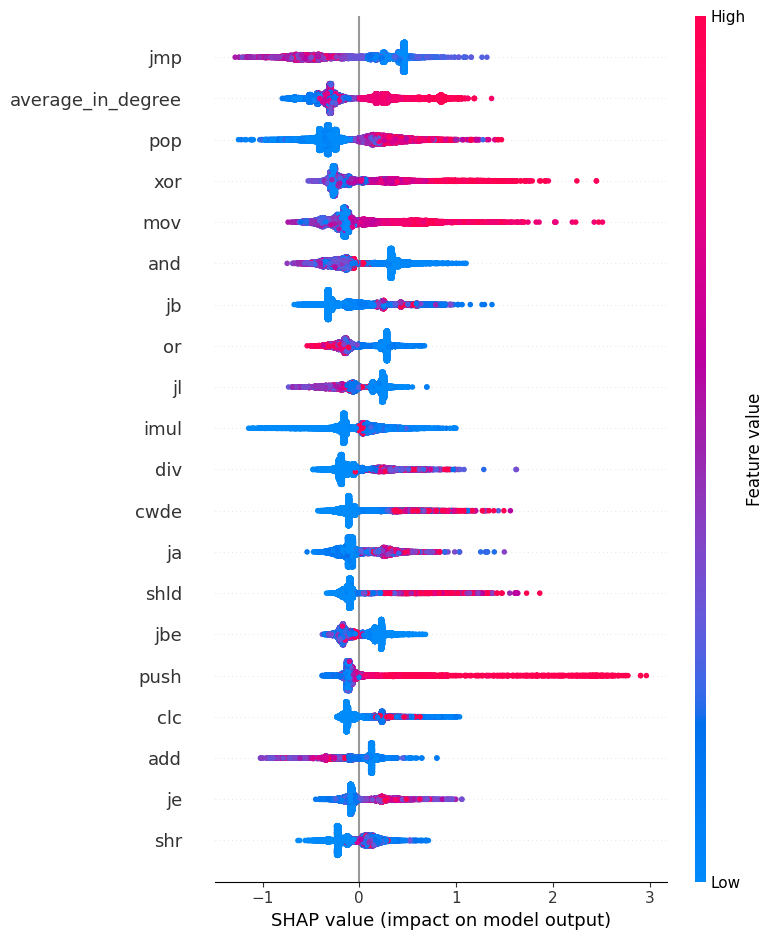

In [5]:
import shap

y_pred = model.predict(X_test)

first_label_classifier = model.estimators_[0]
sample_idx = 0
sample = X_train.iloc[sample_idx:sample_idx+1]

# Appliquer SHAP
explainer = shap.Explainer(first_label_classifier, X_train)
shap_values = explainer.shap_values(X_train, check_additivity=False)
#shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train)

#### Local Shap

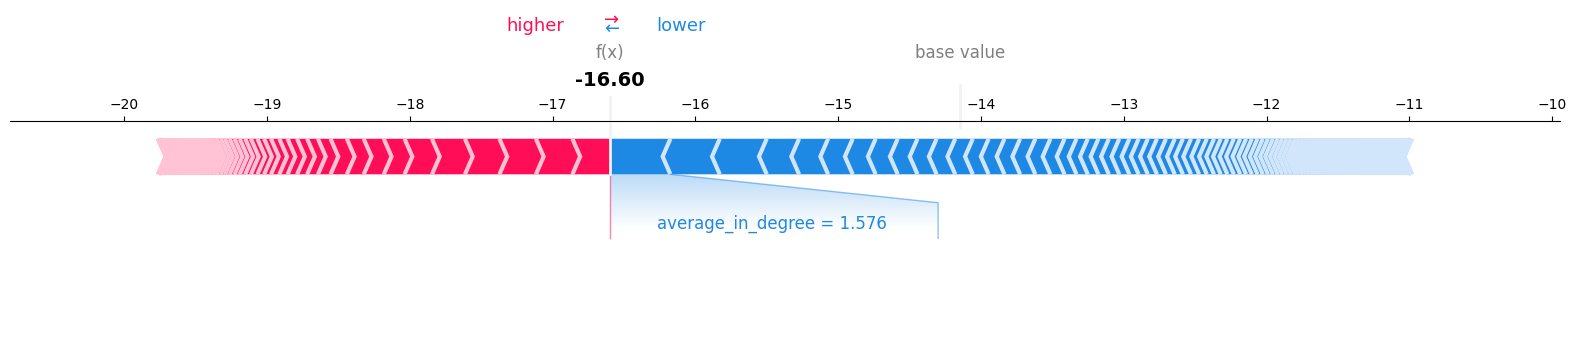

In [5]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[2], sample.apply(lambda x : x.round(3)), matplotlib=True)

#### **PDP** - Global

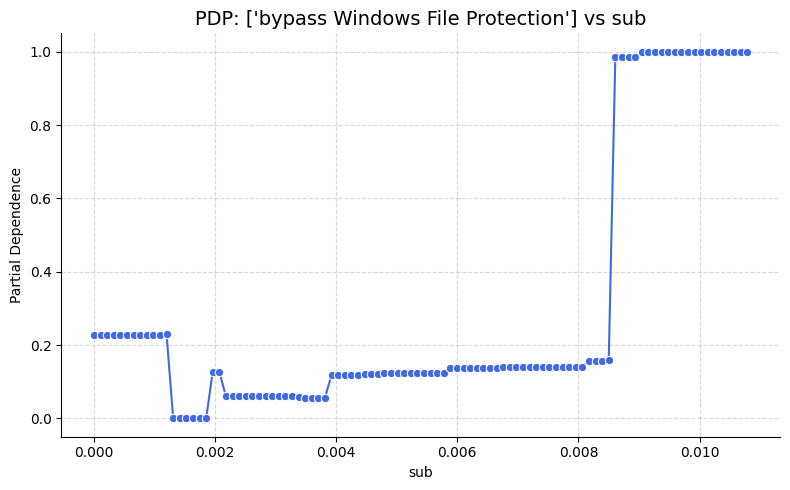

In [6]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

# Choose a feature to inspect
feature_to_plot = 'sub'  # e.g., 'age', 'height', etc.
label_names= ['bypass Windows File Protection']

# Loop through each binary classifier in OVR
for i, estimator in enumerate(model.estimators_[:1]):

    # PDP for one feature
    #PartialDependenceDisplay.from_estimator(estimator, X, [feature_to_plot])
    #plt.title(f'PDP for class: {label_names[i]} - Feature: {feature_to_plot}')
    #plt.show()
    
    # Get PDP values
    pdp_result = partial_dependence(estimator, X_test, [feature_to_plot], kind='average')

    # Extract values
    scaler = MinMaxScaler()
    
    feature_values = pdp_result['grid_values'][0]
    pdp_values = pdp_result['average'][0]
    
    # Ensure feature_values is a NumPy array
    #feature_values = np.array(pdp_result['grid_values'][0]).reshape(-1, 1)
    pdp_values = np.array(pdp_result['average'][0]).reshape(-1, 1)
    
    #feature_values_scaled = scaler.fit_transform(feature_values).flatten()
    pdp_values_scaled = scaler.fit_transform(pdp_values).flatten()

    # Put into DataFrame
    df_pdp = pd.DataFrame({
        feature_to_plot: feature_values,
        'Partial Dependence': pdp_values_scaled
    })

    # Plot with Seaborn
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=df_pdp, x=feature_to_plot, y='Partial Dependence', marker='o', color='royalblue')
    sns.despine()
    plt.title(f"PDP: {label_names} vs {feature_to_plot}", fontsize=14)
    plt.xlabel(feature_to_plot)
    plt.ylabel("Partial Dependence")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

Dans la figure precedente on présente le PDP plot pour la variable 'by pass windows File Protection'. Ce plot présente l'impacte de la valeur de cette variable sur la prédiction du modèle. Pour des faibles valeurs (plus petite que 0.008) l'impacte est faible parcontre l'impacte augmente pour les valeurs plus importantes.

#### **ALE** - Global

In [33]:
from alibi.explainers import ALE, plot_ale

In [34]:
features = X_train.columns.tolist()
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()

In [39]:
estimator_1 = model.estimators_[0]

# Alibi requires a callable that returns predictions
def predict_fn(X):
    return estimator_1.predict(X)

# Initialize ALE explainer
ale_explainer = ALE(predict_fn, feature_names=features, target_names= ['sub'])

# Fit ALE on the data
ale_exp = ale_explainer.explain(X_train_np)

In [ ]:
# Configuration
feature_to_plot = 'sub'
label_names = ['bypass Windows File Protection']

# Get ALE data for the desired feature
feature_idx = X_test.columns.get_loc(feature_to_plot)
ale_feature = ale_exp.ale_values[feature_idx]
ale_grid = ale_exp.feature_values[feature_idx]

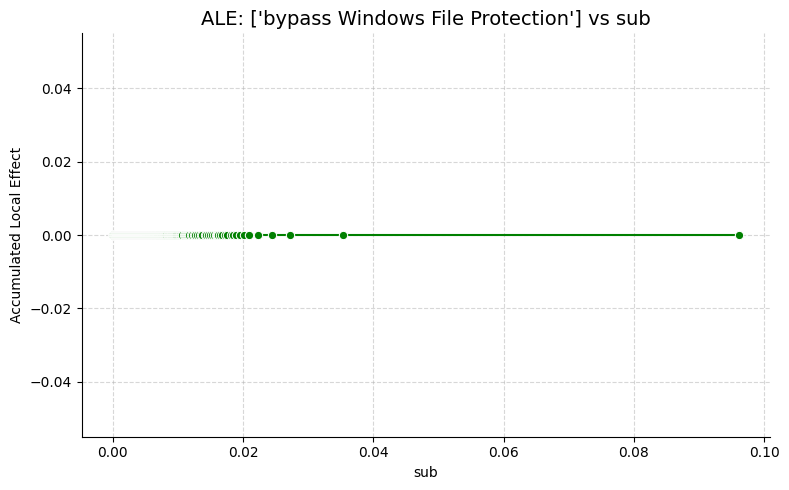

In [ ]:


# Optionally scale ALE values
scaler = MinMaxScaler()
ale_scaled = scaler.fit_transform(ale_feature.reshape(-1, 1)).flatten()

# Create DataFrame for plotting
df_ale = pd.DataFrame({
    feature_to_plot: ale_grid,
    'ALE': ale_scaled
})

# Plot ALE curve
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_ale, x=feature_to_plot, y='ALE', marker='o', color='green')
sns.despine()
plt.title(f"ALE: {label_names} vs {feature_to_plot}", fontsize=14)
plt.xlabel(feature_to_plot)
plt.ylabel("Accumulated Local Effect")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### **LOFO** - Global

La méthode **LOFO (Leave One Feature Out)** est une technique d’interprétabilité qui consiste à mesurer l’importance d’une variable en réentraînant le modèle sans cette variable, puis en comparant la performance du nouveau modèle avec celle du modèle d’origine. L’idée de base est simple : si une variable est vraiment utile, sa suppression devrait dégrader les performances du modèle. À l’inverse, si elle est peu informative, l’impact sera négligeable.

L’intuition derrière LOFO est la suivante : si la suppression d’une variable entraîne un changement significative des performances prédictives, cela indique que cette variable joue un rôle important dans les prédictions. Si les performances restent similaires, cela signifie que la variable n’apporte pas d’information précieuse. Dans certains cas, on peut même observer une amélioration des performances après la suppression d’une variable, ce qui indique une importance **négative** : la variable nuisait à la qualité du modèle, peut-être en introduisant du bruit ou de la redondance.

Pour obtenir l’importance LOFO de toutes les variables, on doit réentraîner le modèle **autant de fois qu’il y a de variables**, en supprimant à chaque fois une variable différente. À chaque itération, on mesure la performance du modèle obtenu sur un jeu de test. Cette méthode est donc très intuitive et facile à mettre en œuvre, mais elle peut être **coûteuse en temps de calcul**, surtout si le modèle est complexe ou si le nombre de variables est élevé.

En résumé, LOFO fournit une estimation conditionnelle de l’importance d’une variable, car elle évalue la performance du modèle en tenant compte de l'ensemble des autres variables présentes. Elle permet de détecter les variables réellement influentes et d’identifier celles qui peuvent être retirées sans perte de performance, voire avec un gain.

**Données et Notation:**
- **Modèle entraîné** : $\hat{f}$
- **Données d'entraînement** : $(\mathbf{X}_{\text{train}}, \mathbf{y}_{\text{train}})$
- **Données de test** : $(\mathbf{X}_{\text{test}}, \mathbf{y}_{\text{test}})$
- **Fonction de perte (erreur)** : $L(y, \hat{y})$
- **Nombre d’exemples de test** : $n_{\text{test}}$

**Formumation Mathematique**:
1. Calcul de l’erreur du modèle original

On commence par mesurer l'erreur moyenne du modèle initial sur l’ensemble de test :

$$
e_{\text{orig}} = \frac{1}{n_{\text{test}}} \sum_{i=1}^{n_{\text{test}}} L\left(y_{\text{test}}^{(i)}, \hat{f}(x_{\text{test}}^{(i)})\right)
$$

2. Boucle sur chaque variable $j \in \{1, ..., p\}$

Pour chaque variable $j$ :
- Supprimer la variable $j$ des jeux de données d'entraînement et de test, pour obtenir $\mathbf{X}_{\text{train}, -j}$ et $\mathbf{X}_{\text{test}, -j}$.
- Réentraîner un nouveau modèle $\hat{f}_{-j}$ sur $(\mathbf{X}_{\text{train}, -j}, \mathbf{y}_{\text{train}})$.
- Calculer l’erreur sur le nouveau jeu de test :

$$
e_{-j} = \frac{1}{n_{\text{test}}} \sum_{i=1}^{n_{\text{test}}} L\left(y_{\text{test}}^{(i)}, \hat{f}_{-j}(x_{\text{test}, -j}^{(i)})\right)
$$

3. Calcul de l’importance LOFO

On évalue l’importance de la variable $j$ :

- **Comme un rapport** :

$$
\text{LOFO}_j = \frac{e_{-j}}{e_{\text{orig}}}
$$

- **Ou comme une différence** :

$$
\text{LOFO}_j = e_{-j} - e_{\text{orig}}
$$

Plus la valeur est élevée, plus la variable est importante (car sa suppression dégrade la performance).


4. Tri et visualisation

On trie les variables selon leurs scores $\text{LOFO}_j$ décroissants, et on les visualise (souvent sous forme de barres) avec **plot_importance**


Les avantages sont:
- **Simple et intuitive** : chaque variable est testée en conditions réelles.
- **Prise en compte des interactions** entre les variables restantes.
- Fournit une **importance conditionnelle**, contrairement aux approches univariées.
- Peut capturer des **effets nuisibles** : une variable peut avoir une importance négative si elle dégrade le modèle.
- L’implémentation peut être optimisée via du **parallélisme** ou des **sous-échantillonnages**.

Les inconvénients sont:
- **Très coûteuse en calcul** : nécessite de **réentraîner un modèle pour chaque variable**.
- Ne convient pas à des modèles très lents ou à des jeux de données très larges sans optimisation.
- Les résultats peuvent être sensibles au **choix du jeu de test**, surtout si la taille est petite.
- Peut être instable si le modèle n’est pas robuste ou si les données sont très bruitées.
- Hyperparameters tuning is unclear.





In [20]:
model_lofo = model.estimators_[0]
model_lofo 

HistGradientBoostingClassifier(class_weight='balanced', l2_regularization=0.5,
                               learning_rate=0.25, max_depth=8,
                               max_features=0.8, max_iter=400,
                               max_leaf_nodes=53, min_samples_leaf=140,
                               validation_fraction=None)

In [4]:
from lofo import LOFOImportance, Dataset, plot_importance

In [26]:
feature_cols = X_train.columns.tolist()

df = X_train.copy()
df['bypass Windows File Protection'] = y_train['bypass Windows File Protection']

# Créer l’objet Dataset pour LOFO
dataset = Dataset(df=df, target= 'bypass Windows File Protection' , features=feature_cols)

In [27]:
# Calculer l'importance LOFO
lofo = LOFOImportance(dataset, model=model_lofo, scoring="roc_auc", cv=4)

importance_df = lofo.get_importance()

100%|██████████| 290/290 [1:37:31<00:00, 20.18s/it]


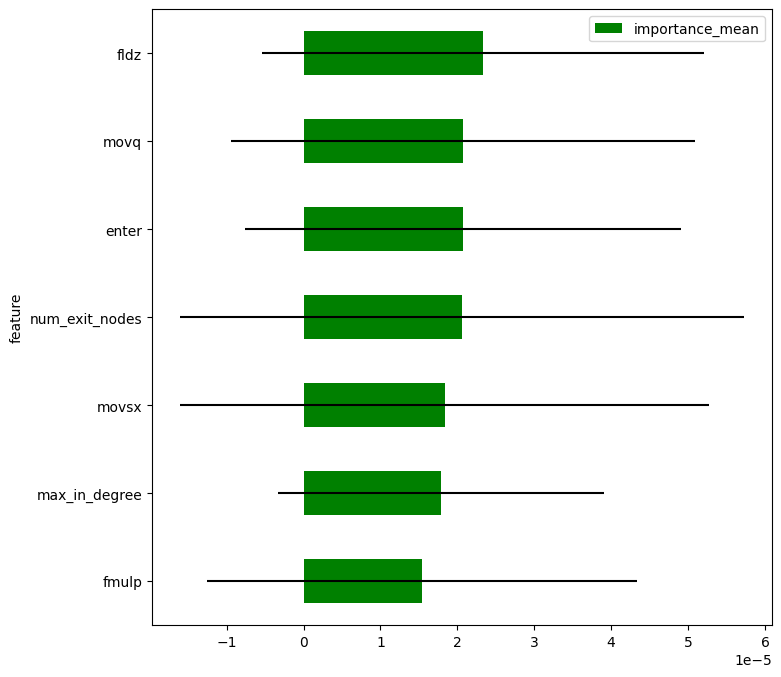

In [29]:
%matplotlib inline
plot_importance(importance_df.iloc[:7])

### **Local Methods**

#### **Lime** - Local

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

#### **ICE** - Local

#### **Anchors** - Local